TcGSA(Time-course Gene Set Analysis) 是一个R包，检验基因动态性表达水平在基因组中的显著性。基因组是已知的具有共同生物学功能或共同表达的一组基因。
TcGSA依赖线性混合模型（linear mixed model）来考虑基因组内标的潜在异质性。

本教程参考https://cran.r-project.org/web/packages/TcGSA/vignettes/TcGSA_userguide.html
本教程所对应的文章 https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004310

# 2. Getting started using TcGSA

运行TcGSA需要输入：

    gene set对象 （The gene set object)
    gene表达矩阵  (The gene expression matrix)
    数据矩阵设计 （design data matrix）


## 2.1 Gene set object

 预定义基因组是一组具有相同生物学功能的基因，它能够检测不同的基因表达，似乎比逐个基因分析更强大。  几个已经做好的基因组，这里我们重点介绍如下几个：

    Chaussabel's modules
    Gene Ontology database
    KEGG

gene set object 是gmt格式，包含有：

    Gene set 名字
    gene set 的描述，比如生物学功能
    表示每个基因集中的基因的探针列表（the list of probes representing the genes inside each gene set)

要么我们使用已经存在的gmt对象，要么自己建一个



### 2.1.1  Download gmts from Hejblum et al., 2015

To import the gmts used in Hejblum et al., 2015, one can download the supplementary file by running the following command:

 使用Hejblum et al.,2015的gmt，利用下面的代码下载：

In [2]:
temp <- tempfile()
utils::download.file("http://doi.org/10.1371/journal.pcbi.1004310.s007", destfile = temp, mode = "wb")
load(unz(temp, "ReproducibleRFiles/GMTs_PLOScb.RData", open = "r"))
unlink(temp)
rm(temp)

它包含上面详细描述的3个基因集(对于GO来说，它只是具有与免疫系统相关的生物学功能的相互排斥的基因集的子集)。

免责声明:小心使用基因集数据库的版本，因为它们可能已经过时了。为了确保拥有最新版本的数据库，您可以(重新)按照下面的方法自己构建gmt对象。

### 2.1.2 Self-built gmt

自建gmt对I下那个，需要准备一个.gmt格式文件，该文件格式 是可以用tab分隔的文件创建的 参考http://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats#GMT:_Gene_Matrix_Transposed_file_format_.28.2A.gmt.29

在这个文件中，每行代表着一个基因集（gene set):

    Column 1： gene set 名称
    Column 2:  gene set 的描述
    剩下的columns： 包含在基因集中的基因列表(用探针表示)

下一步是，导入.gmt文件到R， 需要使用GSA包的GSA.read.gmt()函数。更多内容查看GSA包。

## 2.2 Gene expression matrix

基因表达矩阵 每行一个基因，每个样本一列，  在运行TcGSA之前数据应该规范化。行名为每个基因名或者probe，并且必须与gmt对象的相匹配。

## 2.3 Design data matrix

该矩阵包含每一个样本（每行），几个变量（列）。这些变量是：

    样本名称 （Sample names）
    病人id （Patient identifiers)
    时间  (Time measurements)
    多种处理，处理的名称 (In case of multiple treatments, the name of treatment)

# 3. How to use TcGSA for one treatment group?

## 3.1 Data preparation

这个例子来自Hejblum et al., 2015和DALIA-1 HIV 治疗疫苗实验。

该研究的目的是评估HIV疫苗的免疫反应。

为了开展这个研究，对19名感染艾滋病（HIV）病毒的患者进行了围棋48周的随访，分为2个阶段，每个阶段24例：

    第1阶段从第0周至第24周(治疗中断前):患者接受抗逆转录病毒治疗，第0、4、8和12周接受试验疫苗。
    第2阶段第24周至第48周(治疗中断后):随访患者，未注射试验疫苗，中断抗逆转录病毒治疗(健康问题除外)。

在每个不同的测量时间点，对每个受试者采集血样，研究基因表达随时间的动态变化。

有关数据可于GEO网站公开查阅，网址为https://www.ncbi.nlm.nih.gov/geo/GSE46734

我们将使用GEOquery包从GEO网站获取数据文件(有关GEOquery的详细信息，请参阅附录)

### 3.1.1 Import of data files

在本例中，我们需要使用getGEOSuppFiles()函数导入GEO available的补充文件(我们只需要以下三个文件，因此需要正则表达式过滤器:基因表达pre-ATI、基因表达post-ATI、实验设计)。

In [3]:
GEOquery::getGEOSuppFiles('GSE46734', filter_regex="(*NonParamCombat*)|(*DESIGN*)")

Setting options('download.file.method.GEOquery'='auto')
Setting options('GEOquery.inmemory.gpl'=FALSE)


,size,isdir,mode,mtime,ctime,atime,exe
,<dbl>,<lgl>,<octmode>,<dttm>,<dttm>,<dttm>,<chr>
C:/Users/acer/aaaalab/TcGSA/GSE46734/GSE46734_DALIA1longitudinalTranscriptome_DESIGN_anonym.txt.gz,2262,FALSE,666,2019-05-30 09:13:04,2019-05-30 09:13:03,2019-05-30 09:13:03,no
C:/Users/acer/aaaalab/TcGSA/GSE46734/GSE46734_DALIA1longitudinalTranscriptome_PALO01_PostATI_NEQC_NonParamCombat.txt.gz,47984452,FALSE,666,2019-05-30 09:13:56,2019-05-30 09:13:04,2019-05-30 09:13:04,no
C:/Users/acer/aaaalab/TcGSA/GSE46734/GSE46734_DALIA1longitudinalTranscriptome_PALO01_PreATI_NEQC_NonParamCombat.txt.gz,37333599,FALSE,666,2019-05-30 09:14:37,2019-05-30 09:13:56,2019-05-30 09:13:56,no


### 3.1.2 Design data matrix

设计数据矩阵(称为design_preATI)是从GEO补充文件中提取的。它包含了所需的实验变量，以及一些关于这项研究的附加信息。根据本文的资料来源，进行了一些数据处理。

In [4]:
design <- read.delim(gzfile("GSE46734/GSE46734_DALIA1longitudinalTranscriptome_DESIGN_anonym.txt.gz"))
design_preATI <- design[-which(design$TimePoint<0 | design$TimePoint==16 | design$TimePoint>22), ]
head(design_preATI,5)

,Sample_name,Chip_ID,HYB_Chamber,HYB_Day,Patient_ID,TimePoint
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
1,X6116733008_L,C4,CH1,D1,P001,4
3,X6116733022_E,C13,CH4,D1,P001,22
5,X6116733029_A,C18,CH1,D2,P001,8
6,X6116733068_L,C25,CH3,D2,P001,12
8,X6116733073_K,C29,CH4,D2,P001,0


这个数据框包含90个样本和6个实验变量：

    样本名称 （Sample_name for the name of samples）
    病人ID   （Patient_ID for the identification of patients）
    时间点   （TimePoint for the time measurements）
    芯片ID    （Chip_ID HYB_Chamber HYB_Day are the variables not required for TcGSA commands）

### 3.1.3  Gene expression matrix

基因表达矩阵(称为expr_preATI)是从GEO补充文件(即gse46734_dalia1udinaltranscriptome_palo01_preati_neqc_nonparamcombat.txt .gz文件)中提取的。注意:数据已经标准化。

In [5]:
expr_preATI <- read.delim(gzfile("GSE46734/GSE46734_DALIA1longitudinalTranscriptome_PALO01_PreATI_NEQC_NonParamCombat.txt.gz"))
rownames(expr_preATI) <- expr_preATI$PROBE_ID
expr_preATI <- expr_preATI[,as.character(design_preATI$Sample_name)]

expr_preATI[1:4,1:4]

,X6116733008_L,X6116733022_E,X6116733029_A,X6116733068_L
,<dbl>,<dbl>,<dbl>,<dbl>
ILMN_1762337,4.967101,4.398911,4.384093,4.927489
ILMN_2055271,5.215882,4.744463,5.038972,5.209726
ILMN_2383229,4.565933,4.578123,4.696965,4.306206
ILMN_1806310,4.402265,4.473504,4.598726,4.589389


其中包含：  

    每一行是probe标识符（in row ILMN_xxxxxxx for each probe identifier）
    每一年是每个样本名字（ in column Xxxxxxxxxxx_X for the name of each sample）
    每一个单元包含规范化后的基因表达量（each cell contains the normalized gene expression）

整个表达矩阵包含32978个基因和90个样本（样本数应该跟design data matrix相同）

In [7]:
identical(ncol(expr_preATI),nrow(design_preATI))

[1] TRUE

# 3.2 Likelihood ratios test

This function provides the result of likelihood ratio test using the linear mixed model for each gene set. For this example, we use gene sets data from Chaussabel s modules (Chaussabel et al., 2008). TcGSA.LR function requires

 这个函数使用线性混合模型为每个基因集提供似然比检验的结果，在本例中，我们使用了来自Chaussabel模块，TcGSA.LR()需要：

    expr:           name of the gene expression matrix
                  基因表达矩阵
    gmt:            name of the gmt gene set object
                  基因集对象
    design:          name of the design data matrix
                  数据设计矩阵
    subject_name:      name of the identification of patients in the design data matrix
                  在数据设计矩阵中的病人ID
    time_name:        name of the time measurements in the design data matrix
                  数据设计矩阵的时间测量名称

In [9]:
tcgsa_result <- TcGSA::TcGSA.LR(expr = expr_preATI,
                                    gmt = gmt_modulesV2,
                                    design = design_preATI,
                                    subject_name = "Patient_ID",
                                    time_name = "TimePoint")

boundary (singular) fit: see ?isSingular
1/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
2/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
3/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
4/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00315548 (tol = 0.002, component 1)"boundary (singular) fit: see ?isSingular
5/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00627848 (tol = 0.002, component 1)"boundary (singular) fit: see ?isSingular
6/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
7/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
8/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
9/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
10/260 gene sets ana

"Model failed to converge with max|grad| = 0.0121487 (tol = 0.002, component 1)"86/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
87/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
88/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00690124 (tol = 0.002, component 1)"boundary (singular) fit: see ?isSingular
89/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
90/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
91/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00205648 (tol = 0.002, component 1)"boundary (singular) fit: see ?isSingular
92/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
93/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
94/260 gene sets analyzed

boundary (sin

boundary (singular) fit: see ?isSingular
165/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
166/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
167/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
168/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00298072 (tol = 0.002, component 1)"Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00204034 (tol = 0.002, component 1)"169/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
170/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
171/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
172/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
173/260 gene sets analyzed

Warning message in TcGSA::TcGSA.LR(expr = expr_preATI, gmt = gmt_modulesV2, design =

242/260 gene sets analyzed

243/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00532097 (tol = 0.002, component 1)"boundary (singular) fit: see ?isSingular
244/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
245/260 gene sets analyzed

Warning message in TcGSA::TcGSA.LR(expr = expr_preATI, gmt = gmt_modulesV2, design = design_preATI, :
"The size of the gene set M9.43is problematic (too many or too few genes)
"246/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
247/260 gene sets analyzed

248/260 gene sets analyzed

Warning message in TcGSA::TcGSA.LR(expr = expr_preATI, gmt = gmt_modulesV2, design = design_preATI, :
"The size of the gene set M9.46is problematic (too many or too few genes)
"249/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
250/260 gene sets analyzed

Warning message in TcGSA::TcGSA.LR(expr = expr_preATI, gmt = g

我们先来看看这些参数对应的数据结构

In [12]:
head(expr_preATI)

,X6116733008_L,X6116733022_E,X6116733029_A,X6116733068_L,X6116733073_K,X6116733006_D,X6116733006_E,X6116733011_D,X6116733024_H,X6116733056_I,...,X6116733006_F,X6116733011_J,X6116733028_A,X6116733062_L,X6116733068_I,X6116733006_C,X6116733013_G,X6116733018_L,X6116733030_H,X6116733030_L
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ILMN_1762337,4.967101,4.398911,4.384093,4.927489,4.668973,4.504526,4.635031,4.639166,4.502248,4.945035,...,4.495081,4.843444,4.898256,4.638799,4.424340,4.825314,4.789153,4.444074,4.555402,4.555422
ILMN_2055271,5.215882,4.744463,5.038972,5.209726,5.300074,5.453757,5.263745,5.297377,4.758388,5.791465,...,4.843072,5.365030,4.820607,4.907081,4.896150,4.719724,5.168244,5.194159,4.788828,4.829186
ILMN_2383229,4.565933,4.578123,4.696965,4.306206,4.728350,4.486775,4.540084,4.937307,4.447651,4.542966,...,4.404330,4.345473,5.251877,4.461974,4.333122,4.382050,4.563549,4.591801,4.438846,4.774212
ILMN_1806310,4.402265,4.473504,4.598726,4.589389,4.744017,4.778476,4.536725,4.424008,4.903831,4.519298,...,4.798873,4.534573,4.542421,4.585813,4.568653,4.575264,4.781890,4.838768,4.696778,4.814345
ILMN_1653355,5.134190,4.822575,4.744716,4.755171,4.803524,4.621393,4.596691,4.484480,4.708052,5.054947,...,4.757640,4.740836,4.817267,5.202435,5.333554,4.320445,4.875698,4.552092,4.965799,4.358496
ILMN_1705025,4.539801,4.940543,4.904852,4.547553,4.666069,4.640100,4.594244,5.115789,4.637267,4.449883,...,4.844386,4.920824,5.187519,4.615609,4.582710,4.775750,5.293690,4.917508,5.249189,4.695216


In [14]:
str(gmt_modulesV2)

List of 3
 $ genesets            :List of 260
  ..$ : chr [1:92] "ILMN_1743290" "ILMN_1752755" "ILMN_1713731" "ILMN_1657683" ...
  ..$ : chr [1:36] "ILMN_1695404" "ILMN_1699331" "ILMN_1658247" "ILMN_1707695" ...
  ..$ : chr [1:148] "ILMN_1811221" "ILMN_1692145" "ILMN_1653412" "ILMN_1755114" ...
  ..$ : chr [1:304] "ILMN_1668963" "ILMN_1761170" "ILMN_1873124" "ILMN_1915621" ...
  ..$ : chr [1:77] "ILMN_1772809" "ILMN_1774091" "ILMN_1680652" "ILMN_1694325" ...
  ..$ : chr [1:89] "ILMN_1728742" "ILMN_1654118" "ILMN_1714765" "ILMN_1698557" ...
  ..$ : chr [1:151] "ILMN_1737314" "ILMN_1651826" "ILMN_1653871" "ILMN_1701837" ...
  ..$ : chr [1:50] "ILMN_1806040" "ILMN_1663390" "ILMN_1663332" "ILMN_1736090" ...
  ..$ : chr [1:63] "ILMN_1781373" "ILMN_1859584" "ILMN_1798181" "ILMN_1691731" ...
  ..$ : chr [1:151] "ILMN_1795346" "ILMN_1712390" "ILMN_1756311" "ILMN_1742577" ...
  ..$ : chr [1:54] "ILMN_1799134" "ILMN_1660732" "ILMN_1784287" "ILMN_1723944" ...
  ..$ : chr [1:69] "ILMN_1911677" "IL

In [15]:
head(design_preATI)

,Sample_name,Chip_ID,HYB_Chamber,HYB_Day,Patient_ID,TimePoint
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
1,X6116733008_L,C4,CH1,D1,P001,4
3,X6116733022_E,C13,CH4,D1,P001,22
5,X6116733029_A,C18,CH1,D2,P001,8
6,X6116733068_L,C25,CH3,D2,P001,12
8,X6116733073_K,C29,CH4,D2,P001,0
19,X6116733006_D,C3,CH1,D1,P002,12


查看TcGSA::TcGSA.LR()结果

In [16]:
tcgsa_result

		A TcGSA object
Form of the time trend:
	linear
Number of treatment groups:
	1
Number of gene sets tested for significant time trend:
	260

tcgsa_result是一个tcgsa对象，包含了似然比检验的结果：

    the form of tested time trends (default option is linear)
    测试时间趋势的形式(默认选项为线性)
    the number of treatment groups and the number of gene sets tested (depending on which gene set base is defined)
    治疗组的数量和测试的基因组的数量(取决于定义的基因组基数)
    a few other information
    其他一些信息
    
要获得重要基因集的数量，可以对tcgsa对象使用summary():

In [17]:
summary(tcgsa_result)

		A TcGSA object
Form of the time trend:
	linear
Number of treatment groups:
	1
Number of gene sets tested for significant time trend:
	260

Number of significant gene sets at a 5% threshold (BY procedure):
	17 out of 260 gene sets

利用TcGSA::signifLRT.TcGSA()函数获取更多gene set(基因集)的详细内容。返回的结果包括有显著性的基因组，p值（默认是 Benjamini-Yekutieli相关和5%阈值的多重检验调整后的p值）

In [18]:
TcGSA::signifLRT.TcGSA(tcgsa_result)

,GeneSet,AdjPval,desc
,<fct>,<dbl>,<fct>
1,M1.1,8.296095e-09,Platelets
2,M3.2,4.096446e-08,Inflammation
3,M3.5,3.952333e-02,Cell Cycle
6,M4.6,1.337921e-06,Inflammation
7,M4.9,3.820229e-04,Undetermined
4,M4.11,7.411548e-07,Plasma Cells
5,M4.13,2.378840e-10,Inflammation
9,M5.4,4.757069e-15,Undetermined
10,M5.6,2.373703e-06,Mitochondrial Stress / Proteasome


In [19]:
head(TcGSA::signifLRT.TcGSA(tcgsa_result)$mixedLRTadjRes)

,GeneSet,AdjPval,desc
,<fct>,<dbl>,<fct>
1,M1.1,8.296095e-09,Platelets
2,M3.2,4.096446e-08,Inflammation
3,M3.5,3.952333e-02,Cell Cycle
6,M4.6,1.337921e-06,Inflammation
7,M4.9,3.820229e-04,Undetermined
4,M4.11,7.411548e-07,Plasma Cells


同样，可以使用TcGSA::multtest.TcGSA()来提供似然比，整个基因集的原始p值和调整p值，阈值为5%。

In [21]:
head(TcGSA::multtest.TcGSA(tcgsa_result))

LR,CVG_H0,CVG_H1,raw_pval,adj_pval
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48.5951384,0,0,1.559072e-11,8.296095e-09
0.4574752,0,0,6.471718e-01,1.000000e+00
3.1626408,0,0,1.405223e-01,1.000000e+00
1.6726757,0,0,3.145975e-01,1.000000e+00
0.1412256,0,0,8.194441e-01,1.000000e+00
0.1036536,0,0,8.484909e-01,1.000000e+00


CVG_H0和CVG_H1是在零假设和备选假设下的集合（收敛性 convergence）。 0 意味着是一个好的convergence模型。

# 3.3 Graphical outputs

plot1GS() plots the different representations of gene expression in a specific gene set of interest (specified by the  geneset.name argument). This function requires the following:

 plot1GS()对感兴趣的特定基因集中基因表达的不同表达（由geneset name 参数指定）。参数如下：
 
    expr:        either the name of the gene expression matrix or the estimations of linear mixed model (in this example, we used the raw data from the gene expression matrix)
               要么是基因表达矩阵要么是线性混合模型的估计值（在本例中，使用原始数据基因表达矩阵
               
    gmt:         the name of the gmt gene set object
               gene set对象名称
               
    Subject_ID:    the name of the identification of patients in the design data matrix
               数据设计矩阵中病人id的名称
               
    TimePoint:     the name of the time measurements of the design data matrix
                数据设计矩阵的时间测量名称
                
    geneset.name:   the name of gene set (significant ones can be found with signifLRT.TcGSA(tcgsa_result)$mixedLRTadjRes)
                gene set 名称
                
    time_unit:      string to be displayed before to the values of TimePoint on the x-axis (such as ‘D’ for ‘days’ for instance - optional)
                要在此之前显示到x轴上的时间点值的字符串

Optimally clustering...

DONE

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


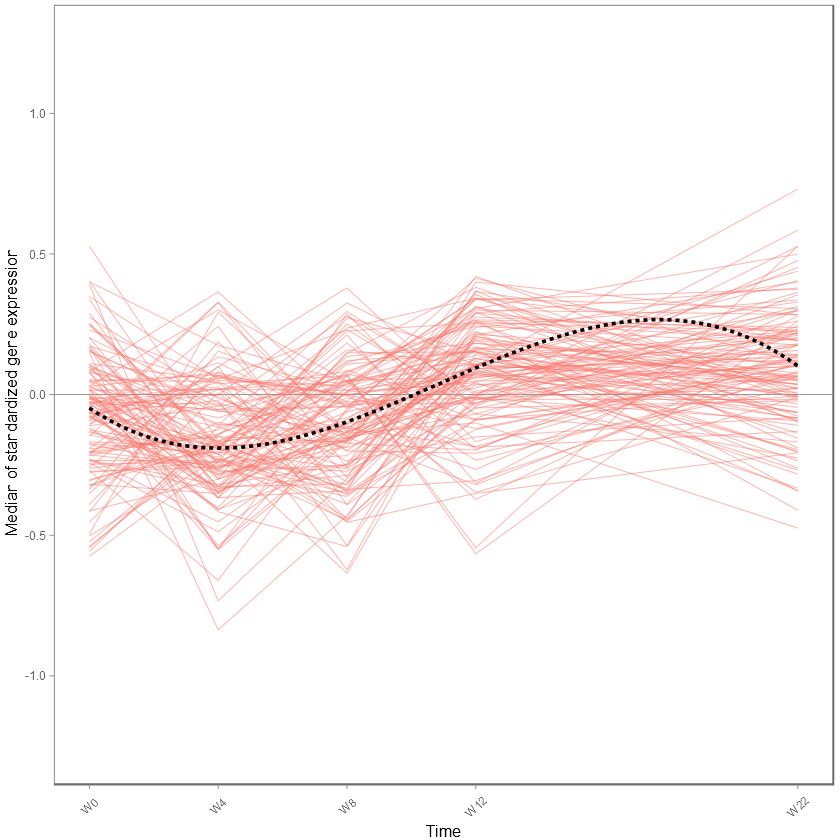

In [22]:
TcGSA::plot1GS(expr = expr_preATI, 
               #plot1GS(expr = tcgsa_result$Estimations,
               gmt = gmt_modulesV2, 
               Subject_ID = design_preATI$Patient_ID, 
               TimePoint = design_preATI$TimePoint,
               clustering = FALSE, 
               time_unit = "W", 
               geneset.name = "M3.2", 
               title="",
               margins=0.4,
               lab.cex=0.37,
               axis.cex=0.37,
               line.size=0.45,
               gg.add=list(ggplot2::theme(legend.position="none"),
                        ggplot2::ylim(-1.26,1.26)
               ))

# 4 How to use TcGSA for several treatment group?

这里我们将以Obermoser等人2013年的另一个例子为例，使用纵向基因表达研究健康人对流感和肺炎球菌疫苗的反应。受试者被分为三组，每组6人，每组接受2009-2010年季节性流感疫苗(Fluzone)、23价肺炎球菌疫苗(Pneumovax23)或安慰剂(生理盐水)。

在第0、1、3、7、10、14、21和28天采集血样，研究基因随时间的表达。更多细节，请查看Obermoser等人的文章。https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3492754/

数据在GEO数据库中，编号为GSE30101，我们可以通过GEOquery包获取数据

## 4.1 Data preparation

下载数据

In [23]:
utils::download.file("ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE30nnn/GSE30101/soft/GSE30101_family.soft.gz", destfile = "GSE30101_family.soft.gz", mode = "wb", cacheOK = FALSE)
gse.soft <- GEOquery::getGEO(filename="GSE30101_family.soft.gz")

Reading file....
Parsing....
Found 694 entities...
GPL6947 (1 of 695 entities)
GSM744141 (2 of 695 entities)
GSM744142 (3 of 695 entities)
GSM744143 (4 of 695 entities)
GSM744144 (5 of 695 entities)
GSM744145 (6 of 695 entities)
GSM744146 (7 of 695 entities)
GSM744147 (8 of 695 entities)
GSM744148 (9 of 695 entities)
GSM744149 (10 of 695 entities)
GSM744150 (11 of 695 entities)
GSM744151 (12 of 695 entities)
GSM744152 (13 of 695 entities)
GSM744153 (14 of 695 entities)
GSM744154 (15 of 695 entities)
GSM744155 (16 of 695 entities)
GSM744156 (17 of 695 entities)
GSM744157 (18 of 695 entities)
GSM744158 (19 of 695 entities)
GSM744159 (20 of 695 entities)
GSM744160 (21 of 695 entities)
GSM744161 (22 of 695 entities)
GSM744162 (23 of 695 entities)
GSM744163 (24 of 695 entities)
GSM744164 (25 of 695 entities)
GSM744165 (26 of 695 entities)
GSM744166 (27 of 695 entities)
GSM744167 (28 of 695 entities)
GSM744168 (29 of 695 entities)
GSM744169 (30 of 695 entities)
GSM744170 (31 of 695 entities)

GSM745020 (259 of 695 entities)
GSM745021 (260 of 695 entities)
GSM745022 (261 of 695 entities)
GSM745023 (262 of 695 entities)
GSM745024 (263 of 695 entities)
GSM745025 (264 of 695 entities)
GSM745026 (265 of 695 entities)
GSM745027 (266 of 695 entities)
GSM745028 (267 of 695 entities)
GSM745029 (268 of 695 entities)
GSM745030 (269 of 695 entities)
GSM745031 (270 of 695 entities)
GSM745032 (271 of 695 entities)
GSM745033 (272 of 695 entities)
GSM745034 (273 of 695 entities)
GSM745035 (274 of 695 entities)
GSM745036 (275 of 695 entities)
GSM745037 (276 of 695 entities)
GSM745038 (277 of 695 entities)
GSM745039 (278 of 695 entities)
GSM745040 (279 of 695 entities)
GSM745041 (280 of 695 entities)
GSM745042 (281 of 695 entities)
GSM745043 (282 of 695 entities)
GSM745044 (283 of 695 entities)
GSM745045 (284 of 695 entities)
GSM745046 (285 of 695 entities)
GSM745047 (286 of 695 entities)
GSM745048 (287 of 695 entities)
GSM745049 (288 of 695 entities)
GSM745050 (289 of 695 entities)
GSM74505

GSM745277 (516 of 695 entities)
GSM745278 (517 of 695 entities)
GSM745279 (518 of 695 entities)
GSM745280 (519 of 695 entities)
GSM745281 (520 of 695 entities)
GSM745282 (521 of 695 entities)
GSM745283 (522 of 695 entities)
GSM745284 (523 of 695 entities)
GSM745285 (524 of 695 entities)
GSM745286 (525 of 695 entities)
GSM745287 (526 of 695 entities)
GSM745288 (527 of 695 entities)
GSM745289 (528 of 695 entities)
GSM745290 (529 of 695 entities)
GSM745291 (530 of 695 entities)
GSM745292 (531 of 695 entities)
GSM745293 (532 of 695 entities)
GSM745294 (533 of 695 entities)
GSM745295 (534 of 695 entities)
GSM745296 (535 of 695 entities)
GSM745297 (536 of 695 entities)
GSM745298 (537 of 695 entities)
GSM745299 (538 of 695 entities)
GSM745300 (539 of 695 entities)
GSM745301 (540 of 695 entities)
GSM745302 (541 of 695 entities)
GSM745303 (542 of 695 entities)
GSM745304 (543 of 695 entities)
GSM745305 (544 of 695 entities)
GSM745306 (545 of 695 entities)
GSM745307 (546 of 695 entities)
GSM74530

**对该基因表达矩阵进行必要的处理**

In [26]:
#获取数据矩阵
probesIDs <- GEOquery::Table(GEOquery::GSMList(gse.soft)[[1]])$ID
data.matrix <- do.call('cbind', lapply(GEOquery::GSMList(gse.soft),
                                       function(x) {
                                        tab <- GEOquery::Table(x)
                                        mymatch <- match(probesIDs,tab$ID_REF)
                                        return(tab$VALUE[mymatch])
                                       }))
#为数据矩阵添加行名
rownames(data.matrix) <- probesIDs
#将每个数据值转换成数值型
expr.All.ChaussVac <- apply(X = data.matrix, MARGIN = 2, FUN = as.numeric)
#为数据矩阵添加行名
rownames(expr.All.ChaussVac) <- probesIDs

**实验设计数据矩阵**

In [27]:
design_list <- lapply(GEOquery::GSMList(gse.soft), 
                      function(x){GEOquery::Meta(x)$characteristics_ch1})


#为design添加行名
design <- data.frame(row.names = names(design_list))


#为design添加sample_ID这一列
design$sample_ID <- names(design_list)


#为design添加Subject_ID这一列
s_id <- unlist(lapply(design_list, 
                      function(x){
                        gsub("subject id: ", "", 
                             #gsub用于字段的删减、增补、替换和切合，可以处理一个字段也可以处理由字段组成的向量。
                             #gsub("目标字符","替换字符",对象)
                             x[grep("subject id: ", x)])}))
                            #grep()输出向量下标或值，通过正则表达式在给定对象中搜索文本
design$Subject_ID <- as.character(paste("P", s_id[design$sample_ID], sep=""))


#为design添加time这一列
time <- unlist(lapply(design_list, function(x){gsub("day: ", "", x[grep("day: ", x)])}))
time[which(time %in% c("-7", "0.5", "1", "7", "10", "14",  "21", "28"))] <-
    paste("D", time[which(time %in% c("-7", "0.5", "1", "7", "10", "14", "21", "28"))], sep="")
time[which(time %in% c("-168", "1.5", "6", "9", "12", "15", "24", "36", "48"))] <-
    paste("H", time[which(time %in% c("-168", "1.5", "6", "9", "12", "15", "24", "36", "48"))], sep="")
design$Time <- as.character(time[design$sample_ID])


#为design添加Vaccine这一列
vac <- unlist(lapply(design_list, function(x){
    gsub("vaccine: ", "", x[grep("vaccine: ", x)])
}))
vac <- as.factor(vac)
levels(vac) <- c("influenza", "influenza", "influenza", "influenza", "saline", 
                 "pneumo", "pneumo", "pneumo", "saline", "saline")
design$Vaccine <- as.character(vac[design$sample_ID])


#为design添加sampSet这一列
sampSet <- unlist(lapply(design_list, function(x){
    gsub("sample set: ", "", x[grep("sample set: ", x)])
}))
design$sampSet <- as.character(sampSet[design$sample_ID])


#为design中的Time这一列更改
design$Time[which(design$sampSet=="Training_Set_Vein" & design$Time %in% c("0", "3"))] <-
    paste("D", design$Time[which(design$sampSet=="Training_Set_Vein" & design$Time %in% c("0", "3"))], sep="")
design$Time[which(design$sampSet=="Training_Set_Finger" & design$Time %in% c("0", "3"))] <-
    paste("H", design$Time[which(design$sampSet=="Training_Set_Finger" & design$Time %in% c("0", "3"))], sep="")
design$Time[which(design$sampSet=="Test_Set_Vein" & design$Time %in% c("0", "3"))] <-
    paste("D", design$Time[which(design$sampSet=="Test_Set_Vein" & design$Time %in% c("0", "3"))], sep="")
design$Time[which(design$sampSet=="Test_Set_Finger" & design$Time %in% c("0", "3"))] <-
    paste("D", design$Time[which(design$sampSet=="Test_Set_Finger" & design$Time %in% c("0", "3"))], sep="")
design$Time[which(design$sampSet=="Validation_Vein" & design$Time %in% c("0", "3"))] <-
    paste("D", design$Time[which(design$sampSet=="Validation_Vein" & design$Time %in% c("0", "3"))], sep="")


#为design添加Day这一列
design$Day <- gsub("D", "", design$Time)
design$Day[grep("H", design$Day)] <- as.numeric(gsub("H", "", design$Day[grep("H", design$Day)]))/24
design$Day <- as.numeric(design$Day)

design.All.ChaussVac <- design



# Avg Baseline -----
design.All.ChaussVac.trainSetVein <- design.All.ChaussVac[which(design.All.ChaussVac$sampSet=="Training_Set_Vein"),]
samplesSaline2rmv <- design.All.ChaussVac.trainSetVein[162:214,"sample_ID"]
design.All.ChaussVac.noDup <- design.All.ChaussVac.trainSetVein[-which(design.All.ChaussVac.trainSetVein$sample_ID%in%samplesSaline2rmv),]

design.All.ChaussVac.AvgBl <- design.All.ChaussVac.noDup[which(design.All.ChaussVac.noDup$Day!=0),]
design.All.ChaussVac.AvgBl[which(design.All.ChaussVac.AvgBl$Day==-7),"Day"] <- 0
design.All.ChaussVac.AvgBl[which(design.All.ChaussVac.AvgBl$Time=="D-7"),"Time"] <- "D0"

expr.All.ChaussVac.AvgBl <- expr.All.ChaussVac[, design.All.ChaussVac.AvgBl$sample_ID]
for(p in unique(design.All.ChaussVac.AvgBl$Subject_ID)){
    if(length(which(design.All.ChaussVac.noDup$Subject_ID==p & (design.All.ChaussVac.noDup$Day==0 | design.All.ChaussVac.noDup$Day==-7)))>1){
        expr.All.ChaussVac.AvgBl[, which(design.All.ChaussVac.AvgBl$Subject_ID==p & design.All.ChaussVac.AvgBl$Day==0)] <-
            apply(X=cbind(expr.All.ChaussVac[, design.All.ChaussVac.noDup[which(design.All.ChaussVac.noDup$Subject_ID==p & design.All.ChaussVac.noDup$Day==0), "sample_ID"]],
                          expr.All.ChaussVac[, design.All.ChaussVac.noDup[which(design.All.ChaussVac.noDup$Subject_ID==p & design.All.ChaussVac.noDup$Day==-7), "sample_ID"]]),
                  MARGIN=1, FUN=mean, na.rm=TRUE)
    }
}
rownames(expr.All.ChaussVac.AvgBl) <- probesIDs

if(!all.equal(as.character(design.All.ChaussVac.AvgBl$sample_ID), colnames(expr.All.ChaussVac.AvgBl))){stop("\n\n\nWARNING: EXPRESSION FILE ORDER NOT MATCHING DESIGN FILE\n\n\n")}
design.All.ChaussVac.AvgBl$Subject_ID <- as.factor(design.All.ChaussVac.AvgBl$Subject_ID)


design.PNEUMOvsSALINE.ChaussVac.AvgBl <- design.All.ChaussVac.AvgBl[which(design.All.ChaussVac.AvgBl$Vaccine!="influenza"), ]
design.PNEUMOvsSALINE.ChaussVac.AvgBl$Vaccine <- as.factor(as.character(design.PNEUMOvsSALINE.ChaussVac.AvgBl$Vaccine))



expr.PNEUMOvsSALINE.ChaussVac.AvgBl <- expr.All.ChaussVac.AvgBl[,design.PNEUMOvsSALINE.ChaussVac.AvgBl$sample_ID]

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

## 4.2 Likelihood ratio tests

This function provides the result of likelihood ratio test using the linear mixed model for each gene set. For this example, we use gene sets data from Chaussabel s modules (Chaussabel et al., 2008). TcGSA.LR function requires

 这个函数使用线性混合模型为每个基因集提供似然比检验的结果，在本例中，我们使用了来自Chaussabel模块，TcGSA.LR()需要：

    expr:           name of the gene expression matrix
                  基因表达矩阵
    gmt:            name of the gmt gene set object
                  基因集对象
    design:          name of the design data matrix
                  数据设计矩阵
    subject_name:      name of the identification of patients in the design data matrix
                  在数据设计矩阵中的病人ID
    time_name:        name of the time measurements in the design data matrix
                  数据设计矩阵的时间测量名称

In [28]:
tcgsa_result_MT <- TcGSA::TcGSA.LR(expr = expr.PNEUMOvsSALINE.ChaussVac.AvgBl, 
                                   gmt = gmt_modulesV2,
                                   design = design.PNEUMOvsSALINE.ChaussVac.AvgBl, 
                                   subject_name = "Subject_ID", 
                                   time_name = "Day", 
                                   group_name = "Vaccine")

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
1/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
2/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
3/260 gene sets analyzed

4/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
5/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
6/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
7/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
8/260 gene sets analyzed

9/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
10/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
11/260 gene sets analyzed

boundary (singu

"unable to evaluate scaled gradient"Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge: degenerate  Hessian with 1 negative eigenvalues"74/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
75/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00493333 (tol = 0.002, component 1)"boundary (singular) fit: see ?isSingular
76/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
77/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
78/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00648644 (tol = 0.002, component 1)"79/

"Model failed to converge with max|grad| = 0.00233747 (tol = 0.002, component 1)"125/260 gene sets analyzed

126/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
127/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
128/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
129/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
130/260 gene sets analyzed

131/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00227683 (tol = 0.002, component 1)"132/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
133/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
134/260

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.0129725 (tol = 0.002, component 1)"boundary (singular) fit: see ?isSingular
196/260 gene sets analyzed

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.011549 (tol = 0.002, component 1)"Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00207447 (tol = 0.002, component 1)"197/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
198/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
199/260 gene sets analyzed

Warning message in TcGSA::TcGSA.LR(expr = expr.PNEUMOvsSALINE.ChaussVac.AvgBl, gmt = gmt_modulesV2, :
"The size of the gene set M8.91is problematic (too many or too few genes)
"200/2

"256/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
257/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
258/260 gene sets analyzed

259/260 gene sets analyzed

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
260/260 gene sets analyzed



In [29]:
summary(tcgsa_result_MT)

		A TcGSA object
Form of the time trend:
	linear
Number of treatment groups:
	2
Number of gene sets tested for significant time trend:
	260

Number of significant gene sets at a 5% threshold (BY procedure):
	36 out of 260 gene sets

In [30]:
TcGSA::signifLRT.TcGSA(tcgsa_result_MT)

,GeneSet,AdjPval,desc
,<fct>,<dbl>,<fct>
1,M1.1,1.284340e-09,Platelets
2,M1.2,5.945221e-06,Interferon
3,M2.3,1.633082e-04,Erythrocytes
4,M3.1,1.284340e-09,Erythrocytes
5,M3.2,3.554216e-10,Inflammation
6,M3.4,2.474143e-07,Interferon
7,M3.5,8.365462e-03,Cell Cycle
8,M3.6,5.073592e-05,Cytotoxic/NK Cell
9,M4.1,3.206329e-04,T cell


## 4.3 Graphical outputs for significant gene sets

### 4.3.1 Make clusters from tcgsa object

TcGSA::clustTrend() 从基因的动态趋势中构建基因族，参数如下：

    tcgs: your TcGSA object
        TcGSA对象
    
    expr: estimation of gene expressions with linear mixed model from TcGSA object
        TcGSA对象利用线性混合模型后的基因表达的估计值
    
    Subject_ID: name of the identification of patients in the design data matrix
            数据设计矩阵中的病人ID
    TimePoint: name of the time measurements in the design data matrix
            数据设计矩阵中时间测量的方法的名称
    baseline (optional): value of TimePoint used to be the reference
                   时间点的值
    group_of_interest: name of a treatment in the design data matrix
                数据设计矩阵中处理组的名称

In [32]:
clust <- TcGSA::clustTrend(tcgs = tcgsa_result_MT, 
                           expr=tcgsa_result_MT$Estimations,
                           Subject_ID=design.PNEUMOvsSALINE.ChaussVac.AvgBl$Patient_ID,
                           TimePoint=design.PNEUMOvsSALINE.ChaussVac.AvgBl$Day,
                           group.var = design.PNEUMOvsSALINE.ChaussVac.AvgBl$Vaccine,
                           group_of_interest="pneumo",
                           ref="saline")

1/36 gene sets clustered

2/36 gene sets clustered

3/36 gene sets clustered

4/36 gene sets clustered

5/36 gene sets clustered

6/36 gene sets clustered

7/36 gene sets clustered

8/36 gene sets clustered

9/36 gene sets clustered

10/36 gene sets clustered

11/36 gene sets clustered

12/36 gene sets clustered

13/36 gene sets clustered

14/36 gene sets clustered

15/36 gene sets clustered

16/36 gene sets clustered

17/36 gene sets clustered

18/36 gene sets clustered

19/36 gene sets clustered

20/36 gene sets clustered

21/36 gene sets clustered

22/36 gene sets clustered

23/36 gene sets clustered

24/36 gene sets clustered

25/36 gene sets clustered

26/36 gene sets clustered

27/36 gene sets clustered

28/36 gene sets clustered

29/36 gene sets clustered

30/36 gene sets clustered

31/36 gene sets clustered

32/36 gene sets clustered

33/36 gene sets clustered

34/36 gene sets clustered

35/36 gene sets clustered

36/36 gene sets clustered



In [33]:
clust

			A ClusteredTrends object

Distribution of the number of trends per gene sets:
	1 trend:  36
	2 trends: 0
	3 trends: 0
	4 trends: 0
	Total number of trends: 36 (out of 36 significant gene sets)

Maximal number of clusters tested: 4 

Mean number of trends by significant gene set:    1 

**clust显示重要基因组内的趋势数。**

### 4.3.2 Heatmap of significant gene sets

plot draws different kinds of graphics, but we focus on heatmap graphics. This function requires:

    x: a tcgsa object
    tcgsa 对象
    
    expr: estimation of gene expressions with linear mixed model from a tcgsa object
    TcGSA对象利用线性混合模型后的基因表达的估计值
    
    Subject_ID: name of the subject identifier variable in the design data matrix
    数据设计矩阵中的病人ID
    
    TimePoint: name of the time measurement variable in the design data matrix
    数据设计矩阵中时间测量的方法的名称
    
    group_of_interest: name of the treatment factor variable in the design data matrix
    设计数据矩阵中处理因子变量的名称
    
    clust_trends: cluster object with the clusters of genes from their trends dynamics
    聚类对象：从它们的动态变化趋势聚类的基因

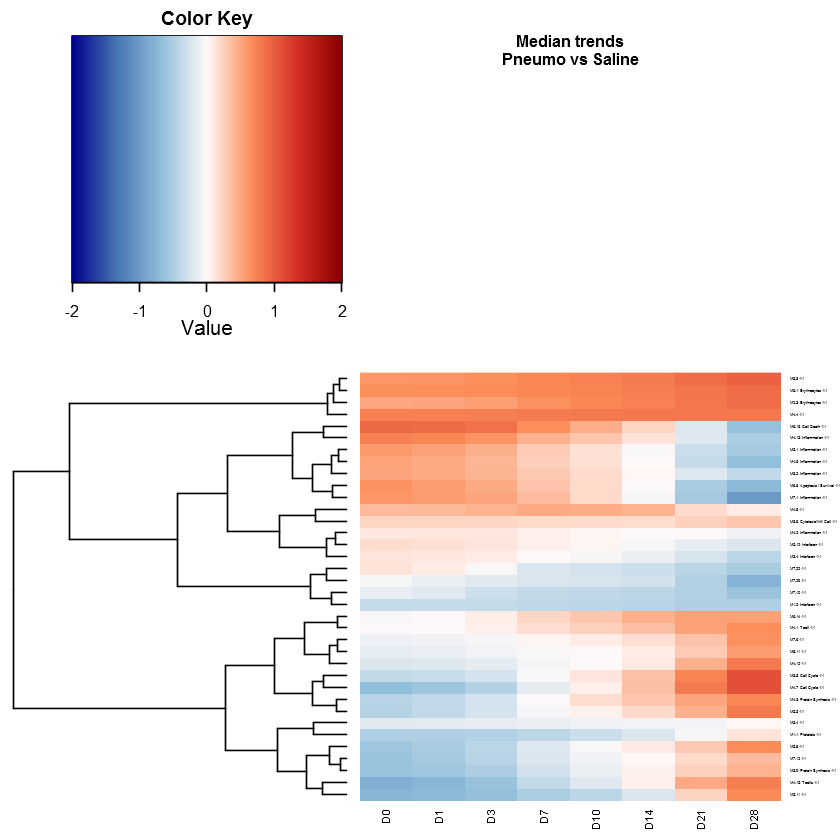

In [34]:
plot(x=tcgsa_result_MT, expr=tcgsa_result_MT$Estimations,
     Subject_ID=design.PNEUMOvsSALINE.ChaussVac.AvgBl$Patient_ID,
     TimePoint=design.PNEUMOvsSALINE.ChaussVac.AvgBl$TimePoint,
     group_of_interest="pneumo",
     clust_trends=clust,
     legend.breaks=seq(from=-2,to=2, by=0.01), time_unit="D",
     subtitle="Pneumo vs Saline", cex.label.row=0.5, cex.label.col=1, cex.main=0.7,
     heatmap.width=0.2, dendrogram.size=0.3, margins=c(2,3),
     heatKey.size=0.8)

热图显示，与来自clust对象的pneoumo相比，saline(vaccine)中每个重要的基因组的表达低于(蓝色)或高于(红色)。类似的表达式动态通过树状图显示的层次聚类进行聚类。

注意:这个图与Hejblum等人的图不同，因为这里我们使用线性时间函数(为了简单和计算速度)。要重现原始文章中的heatmap，必须使用time_func参数指定一个在第1天具有偏移量的二次时间函数。